# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
from getData import getData
#import pandas as pd
import os
cwd = os.getcwd()
data = getData()

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

In [4]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [5]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [6]:
data['Wind (onshore), operationRateMax'].sum()

cluster_0    2300.406907
cluster_1    1082.032187
cluster_2    1447.812026
cluster_3    1448.827987
cluster_4    1935.618218
cluster_5    1757.696047
cluster_6    1286.944636
cluster_7    1199.380071
dtype: float64

### Wind offshore

In [7]:
esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [8]:
data['Wind (offshore), operationRateMax'].sum()

cluster_0    4332.977326
cluster_1       0.000000
cluster_2       0.000000
cluster_3       0.000000
cluster_4    3963.044612
cluster_5    3459.283279
cluster_6       0.000000
cluster_7       0.000000
dtype: float64

### PV

In [9]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

Full load hours:

In [10]:
data['PV, operationRateMax'].sum()

cluster_0    859.175855
cluster_1    970.535848
cluster_2    913.049274
cluster_3    917.880212
cluster_4    875.448945
cluster_5    904.590003
cluster_6    984.223517
cluster_7    992.311727
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [11]:
esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [12]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

### Biogas

In [13]:
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCost=0.05409*1e-3))

## 3.3 CO2

### CO2

The CO2 source is required for the case in which it can be mixed with conventional natural gas.

In [14]:
esM.add(fn.Source(esM=esM, name='CO2 from enviroment', commodity='CO2',
                  hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [15]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.625, 'CO2':201*1e-6/0.625},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycle gas turbine plants for biogas

In [16]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.635},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycly gas turbines for hydrogen

In [17]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [18]:
esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

In [19]:
capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [20]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [21]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))

## 5.3. Methane storage

### Methane filled salt caverns

In [22]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [23]:
esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [24]:
esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix']))

The distances of a component are set to a normalized values of 1.


### DC cables

In [25]:
esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))

## 6.2 Methane transmission

### Methane pipeline

In [26]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas', 
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=False, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000037, investIfBuilt=0.000314,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipelines (methane)')._mapC['cluster_0_cluster_4'][1]

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [27]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=False, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000177, investIfBuilt=0.00033,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipeline (hydrogen)')._mapC

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [28]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [29]:
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [30]:
esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 8. Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [31]:
esM.cluster(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...


c:\users\t.gross\documents\fork-test\fine\FINE\energySystemModel.py:372: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  timeSeriesData = timeSeriesData.reindex_axis(sorted(timeSeriesData.columns), axis=1)


		(3.9420 sec)



In [32]:
esM.optimize(timeSeriesAggregation=True, optimizationSpecs='OptimalityTol=1e-3 cuts=0 method=2')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per periods:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.4692 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1406 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.5798 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2187 sec)

Declaring shared potential constraint...
		(0.0156 sec)

Declaring commodity balances...
		(0.6624 sec)

Declaring objective function...
		(0.4451 sec)

Academic license - for non-commercial use only
Read LP format model from file C:\Users\t.gross\Documents\Fork-Test\FINE\examples\Multi-regiona

In [33]:
for key, mdl in esM.componentModelingDict.items():
    print(mdl)

In [34]:
test = esM.componentModelingDict['SourceSinkModel']
test.getOptimalValues()

{'capacityVariablesOptimum': {'values':                               cluster_0  cluster_1  cluster_2  cluster_3  \
  Existing run-of-river plants        NaN   0.544397   0.455005   0.037456   
  PV                            17.970141  25.807194  18.698614  32.994484   
  Wind (offshore)               16.107011        NaN        NaN        NaN   
  Wind (onshore)                58.169300   0.000000   0.000000   0.000000   
  
                                cluster_4  cluster_5  cluster_6  cluster_7  
  Existing run-of-river plants        NaN   0.043572   2.075538   0.655032  
  PV                            20.883876  39.127909  22.626522  21.891252  
  Wind (offshore)               28.616236  15.276753        NaN        NaN  
  Wind (onshore)                 9.826468  86.046100   0.000000   0.000000  ,
  'timeDependent': False,
  'dimension': '1dim'},
 'isBuiltVariablesOptimum': {'values': None,
  'timeDependent': False,
  'dimension': '1dim'},
 'operationVariablesOptimum': {'values

In [35]:
mdl.getOptimalValues()

{'capacityVariablesOptimum': {'values':                                 cluster_0  cluster_1  cluster_2  cluster_3  \
  AC cables            cluster_0        NaN        NaN        NaN   2.395773   
                       cluster_1        NaN        NaN   8.905339   4.791545   
                       cluster_2        NaN   8.905339        NaN        NaN   
                       cluster_3   2.395773   4.791545        NaN        NaN   
                       cluster_4   3.262664        NaN   8.731961   5.737245   
                       cluster_5   2.395773        NaN        NaN  13.381651   
                       cluster_6        NaN        NaN        NaN   0.945700   
                       cluster_7        NaN   9.866801        NaN   3.593659   
  DC cables            cluster_0        NaN   2.000000        NaN        NaN   
                       cluster_1   2.000000        NaN   2.000000        NaN   
                       cluster_2        NaN   2.000000        NaN        NaN   
  

In [36]:
mdl.optSummary

cluster_0  \
AC cables            TAC       [1e9 Euro/a]           cluster_0           0   
                                                      cluster_1           0   
                                                      cluster_2           0   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
                                                      cluster_6           0   
                                                      cluster_7           0   
                     capacity  [GW$_{el}$]            cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3     2.39577   
                                                      cluster_4     3.26266   
                                                      cluster_5     2.39577   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     capexCap  [1e9 Euro/a]           cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     invest    [1e9 Euro]             cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
...                                                                     ...   
Pipelines (hydrogen) invest    [1e9 Euro]             cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4  0.00124025   
                                                      cluster_5         NaN   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     operation [GW$_{H_{2},LHV}$*h/a] cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4      458.99   
                                                      cluster_5         NaN   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     opexCap   [1e9 Euro/a]           cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4           0   
                                     

# 9. Selected results output

Plot locations (GeoPandas required)

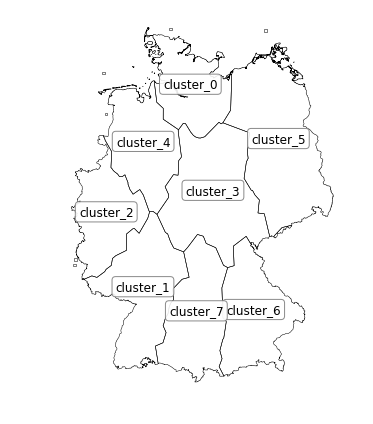

In [37]:
locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'clusteredRegions.shp')
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn='index')

### Sources and Sink

Show optimization summary

In [38]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.450598   
                             commodCosts [1e9 Euro/a]             0.450598   
                             operation   [GW$_{biogas,LHV}$*h/a]   8330.51   
Electricity demand           operation   [GW$_{el}$*h/a]           30957.9   
Existing run-of-river plants TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    4765.07   
PV                           TAC         [1e9 Euro/a]              1.32784   
                             capacity    [GW$_{el}$]               17.9701   
                             capexCap    [1e9 Euro/a]              1.09422   
                             invest      [1e9 Euro]                11.6806   
                             operation   [GW$_{el}$*h/a]           12873.5   
                             opexCap     [1e9 Euro/a]             0.233612   
Wind (offshore)              TAC         [1e9 Euro/a]              4.51415   
                             capacity    [GW$_{el}$]                16.107   
                             capexCap    [1e9 Euro/a]              3.77323   
                             invest      [1e9 Euro]                37.0461   
                             operation   [GW$_{el}$*h/a]             45550   
                             opexCap     [1e9 Euro/a]             0.740923   
Wind (onshore)               TAC         [1e9 Euro/a]              7.79686   
                             capacity    [GW$_{el}$]               58.1693   
                             capexCap    [1e9 Euro/a]              6.51714   
                             invest      [1e9 Euro]                63.9862   
                             operation   [GW$_{el}$*h/a]            104920   
                             opexCap     [1e9 Euro/a]              1.27972   

                                                                 cluster_1  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.407035   
                             commodCosts [1e9 Euro/a]             0.407035   
                             operation   [GW$_{biogas,LHV}$*h/a]   7525.14   
Electricity demand           operation   [GW$_{el}$*h/a]            111621   
Existing run-of-river plants TAC         [1e9 Euro/a]             0.113235   
                             capacity    [GW$_{el}$]              0.544397   
                             operation   [GW$_{el}$*h/a]           2668.85   
                             opexCap     [1e9 Euro/a]             0.113235   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    13481.3   
PV                           TAC         [1e9 Euro/a]              1.90692   
                             capacity    [GW$_{el}$]               25.8072   
                             capexCap    [1e9 Euro/a]              1.57143   
                             invest      [1e9 Euro]                16.7747   
                             operation   [GW$_{el}$*h/a]           25042.5   
                             opexCap     [1e9 Euro/a]             0.335494   
Wind (offshore)              TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             capexCap    [1e9 Euro/a]                  NaN   
                             invest      [1e9 Euro]                    NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Wind (on

Plot installed capacities

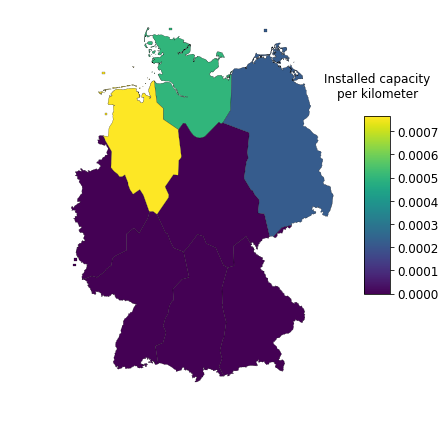

In [39]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (offshore)', locFilePath, 'index', perArea=True)

Plot operation time series (either one or two dimensional)

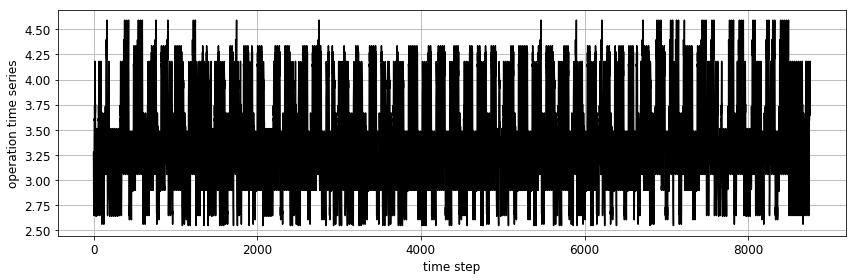

In [40]:
fig, ax = fn.plotOperation(esM, 'Electricity demand', 'cluster_0')

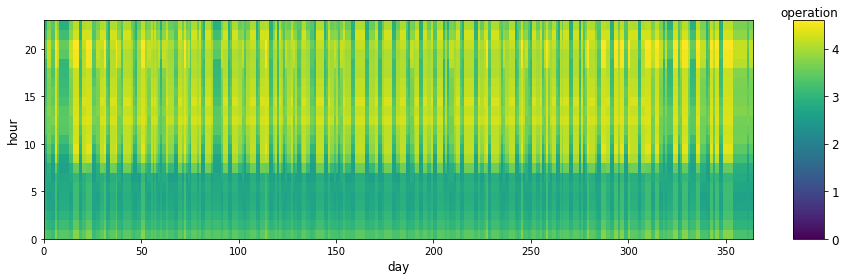

In [41]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'cluster_0')

### Conversion

Show optimization summary

In [42]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

cluster_0   cluster_1  \
Component                  Property  Unit                                    
Electroylzers              TAC       [1e9 Euro/a]      2.15756           0   
                           capacity  [GW$_{el}$]       24.7954           0   
                           capexCap  [1e9 Euro/a]      1.84762           0   
                           invest    [1e9 Euro]        12.3977           0   
                           operation [GW$_{el}$*h/a]   83537.6           0   
                           opexCap   [1e9 Euro/a]     0.309942           0   
New CCGT plants (biogas)   TAC       [1e9 Euro/a]            0    0.146266   
                           capacity  [GW$_{el}$]             0     1.78818   
                           capexCap  [1e9 Euro/a]            0    0.108714   
                           invest    [1e9 Euro]              0     1.25172   
                           operation [GW$_{el}$*h/a]         0     4061.51   
                           opexCap   [1e9 Euro/a]            0   0.0375517   
New CCGT plants (hydrogen) TAC       [1e9 Euro/a]            0  0.00956087   
                           capacity  [GW$_{el}$]             0    0.116887   
                           capexCap  [1e9 Euro/a]            0  0.00710625   
                           invest    [1e9 Euro]              0   0.0818206   
                           operation [GW$_{el}$*h/a]         0      387.83   
                           opexCap   [1e9 Euro/a]            0  0.00245462   

                                                     cluster_2  cluster_3  \
Component                  Property  Unit                                   
Electroylzers              TAC       [1e9 Euro/a]            0          0   
                           capacity  [GW$_{el}$]             0          0   
                           capexCap  [1e9 Euro/a]            0          0   
                           invest    [1e9 Euro]              0          0   
                           operation [GW$_{el}$*h/a]         0          0   
                           opexCap   [1e9 Euro/a]            0          0   
New CCGT plants (biogas)   TAC       [1e9 Euro/a]     0.407002   0.320726   
                           capacity  [GW$_{el}$]       4.97581    3.92104   
                           capexCap  [1e9 Euro/a]      0.30251   0.238384   
                           invest    [1e9 Euro]        3.48307    2.74473   
                           operation [GW$_{el}$*h/a]   11730.1      10116   
                           opexCap   [1e9 Euro/a]     0.104492  0.0823419   
New CCGT plants (hydrogen) TAC       [1e9 Euro/a]     0.484442          0   
                           capacity  [GW$_{el}$]       5.92256          0   
                           capexCap  [1e9 Euro/a]     0.360069          0   
                           invest    [1e9 Euro]        4.14579          0   
                           operation [GW$_{el}$*h/a]   24185.4          0   
                           opexCap   [1e9 Euro/a]     0.124374          0   

                                                      cluster_4  cluster_5  \
Component                  Property  Unit                                    
Electroylzers              TAC       [1e9 Euro/a]      0.673241    1.68521   
                           capacity  [GW$_{el}$]        7.73709     19.367   
                           capexCap  [1e9 Euro/a]      0.576527    1.44313   
                           invest    [1e9 Euro]         3.86855     9.6835   
                           operation [GW$_{el}$*h/a]    24886.3    45568.8   
                           opexCap   [1e9 Euro/a]     0.0967136   0.242088   
New CCGT plants (biogas)   TAC       [1e9 Euro/a]      0.400957   0.104642   
                           capacity  [GW$_{el}$]        4.90191     1.2793   
                           capexCap  [1e9 Euro/a]      0.298017  0.0777766   
                           invest    [1e9 Euro]         3.43133   0.895511   
               

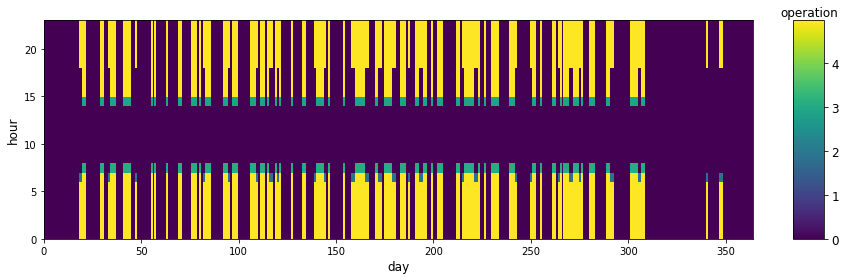

In [43]:
fig, ax = fn.plotOperationColorMap(esM, 'New CCGT plants (biogas)', 'cluster_2')

### Storage

Show optimization summary

In [44]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

cluster_0  \
Component               Property           Unit                                  
Li-ion batteries        TAC                [1e9 Euro/a]              0.0442068   
                        capacity           [GW$_{el}$*h]               2.63091   
                        capexCap           [1e9 Euro/a]               0.038945   
                        invest             [1e9 Euro]                 0.397268   
                        operationCharge    [GW$_{el}$*h/a]             973.967   
                        operationDischarge [GW$_{el}$*h/a]             878.369   
                        opexCap            [1e9 Euro/a]             0.00526182   
Pumped hydro storage    TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{el}$*h]                   NaN   
                        operationCharge    [GW$_{el}$*h/a]                 NaN   
                        operationDischarge [GW$_{el}$*h/a]                 NaN   
                        opexCap            [1e9 Euro/a]                    NaN   
Salt caverns (biogas)   TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{biogas,LHV}$*h]             0   
                        capexCap           [1e9 Euro/a]                      0   
                        invest             [1e9 Euro]                        0   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]           0   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]           0   
                        opexCap            [1e9 Euro/a]                      0   
Salt caverns (hydrogen) TAC                [1e9 Euro/a]               0.716143   
                        capacity           [GW$_{H_{2},LHV}$*h]        1235.22   
                        capexCap           [1e9 Euro/a]              0.0120693   
                        invest             [1e9 Euro]                 0.135874   
                        operationCharge    [GW$_{H_{2},LHV}$*h/a]      6631.17   
                        operationDischarge [GW$_{H_{2},LHV}$*h/a]      6631.17   
                        opexCap            [1e9 Euro/a]               0.704073   

                                                                     cluster_1  \
Component               Property           Unit                                  
Li-ion batteries        TAC                [1e9 Euro/a]               0.344159   
                        capacity           [GW$_{el}$*h]               20.4822   
                        capexCap           [1e9 Euro/a]               0.303195   
                        invest             [1e9 Euro]                  3.09281   
                        operationCharge    [GW$_{el}$*h/a]             7685.54   
                        operationDischarge [GW$_{el}$*h/a]             6933.67   
                        opexCap            [1e9 Euro/a]              0.0409644   
Pumped hydro storage    TAC                [1e9 Euro/a]             0.00137868   
                        capacity           [GW$_{el}$*h]                 9.011   
                        operationCharge    [GW$_{el}$*h/a]             3069.26   
                        operationDischarge [GW$_{el}$*h/a]             2376.76   
                        opexCap            [1e9 Euro/a]             0.00137868   
Salt caverns (biogas)   TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{biogas,LHV}$*h]           NaN   
                        capexCap           [1e9 Euro/a]                    NaN   
                        invest             [1e9 Euro]                      NaN   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]         NaN   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]         NaN   
                        opexCap            [1e9 Euro/a]                    NaN   
Salt caverns (hydrogen) TAC                [1e9 Eu

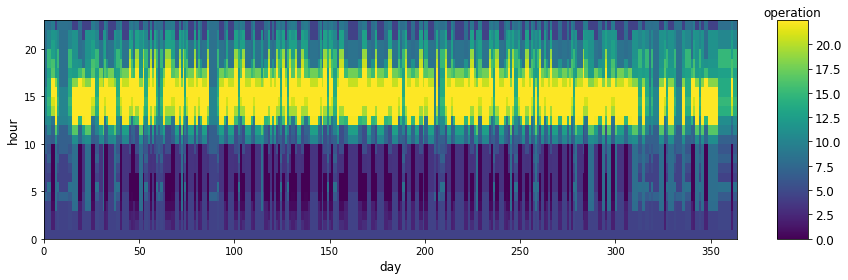

In [45]:
fig, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'cluster_2', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

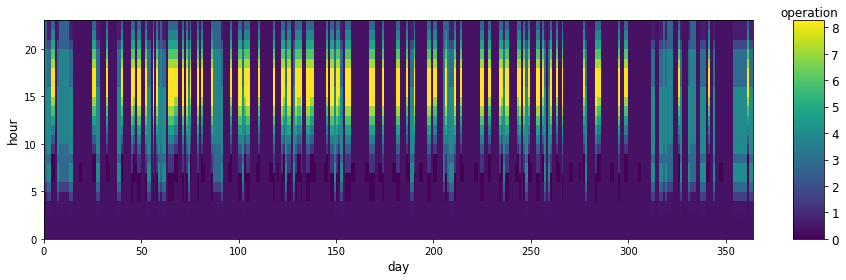

In [46]:
fig, ax = fn.plotOperationColorMap(esM, 'Pumped hydro storage', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

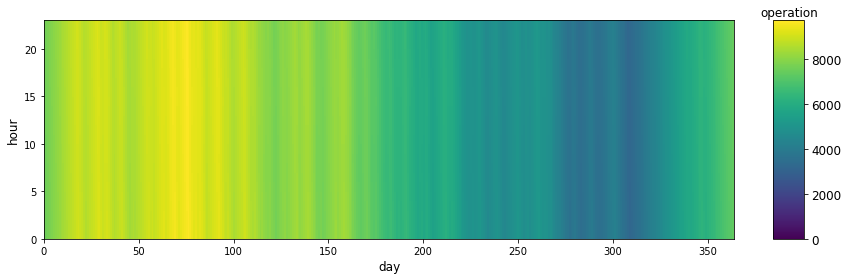

In [47]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (biogas)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

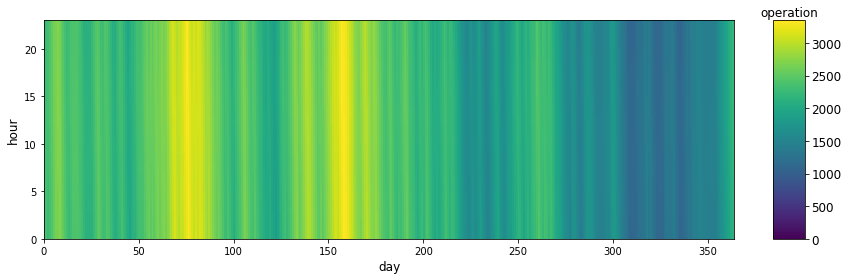

In [48]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (hydrogen)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

## Transmission

Show optimization summary

In [49]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

cluster_0  \
AC cables            capacity  [GW$_{el}$]            cluster_0          NaN   
                                                      cluster_1          NaN   
                                                      cluster_2          NaN   
                                                      cluster_3      2.39577   
                                                      cluster_4      3.26266   
                                                      cluster_5      2.39577   
                                                      cluster_6          NaN   
                                                      cluster_7          NaN   
                     operation [GW$_{el}$*h/a]        cluster_0          NaN   
                                                      cluster_1          NaN   
                                                      cluster_2          NaN   
                                                      cluster_3      300.834   
                                                      cluster_4      447.872   
                                                      cluster_5      4271.62   
                                                      cluster_6          NaN   
                                                      cluster_7          NaN   
DC cables            capacity  [GW$_{el}$]            cluster_0          NaN   
                                                      cluster_1            2   
                                                      cluster_2          NaN   
                                                      cluster_3          NaN   
                                                      cluster_4          NaN   
                                                      cluster_7            2   
                     operation [GW$_{el}$*h/a]        cluster_0          NaN   
                                                      cluster_1          150   
                                                      cluster_2          NaN   
                                                      cluster_3          NaN   
                                                      cluster_4          NaN   
Pipelines (biogas)   TAC       [1e9 Euro/a]           cluster_0            0   
                                                      cluster_1            0   
                                                      cluster_2            0   
...                                                                      ...   
Pipelines (hydrogen) capacity  [GW$_{H_{2},LHV}$]     cluster_1          NaN   
                                                      cluster_2          NaN   
                                                      cluster_3          NaN   
                                                      cluster_4      14.0141   
                                                      cluster_5          NaN   
                                                      cluster_6          NaN   
                                                      cluster_7          NaN   
                     capexCap  [1e9 Euro/a]           cluster_0          NaN   
                                                      cluster_1          NaN   
                                                      cluster_2          NaN   
                                                      cluster_3          NaN   
                                                      cluster_4  0.000104007   
                                                      cluster_5          NaN   
                                                      cluster_6          NaN   
                                                      cluster_7          NaN   
                     invest    [1e9 Euro]             cluster_0          NaN   
                                                      cluster_1          NaN   
                                                      cluster_2          NaN   
                                                      cluster_3    

Check that the shared capacity of the pipelines are not exceeded

In [50]:
df=esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
cluster_0,NaN,NaN,NaN,NaN,14.965040,NaN,NaN,NaN
cluster_1,NaN,NaN,9.565315,NaN,NaN,NaN,NaN,5.197288
cluster_2,NaN,9.565315,NaN,NaN,15.000000,NaN,NaN,NaN
cluster_3,NaN,NaN,NaN,NaN,4.542035,13.523569,NaN,NaN
cluster_4,14.96504,NaN,15.000000,4.542035,NaN,NaN,NaN,NaN
cluster_5,NaN,NaN,NaN,13.523569,NaN,NaN,NaN,NaN
cluster_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.584959
cluster_7,NaN,5.197288,NaN,NaN,NaN,NaN,2.584959,NaN


Plot installed transmission capacities

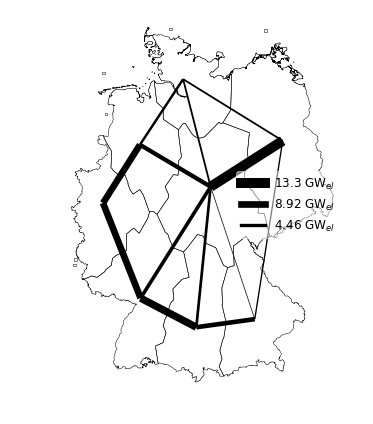

In [51]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'AClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'AC cables', transFilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

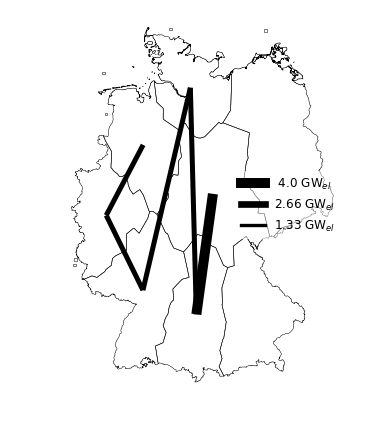

In [52]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'DClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'DC cables', transFilePath, loc0='cluster0', loc1='cluster1', fig=fig, ax=ax)

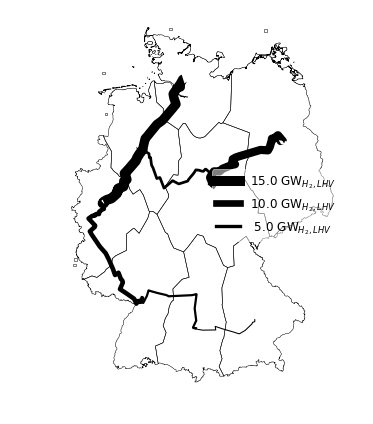

In [53]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (hydrogen)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)

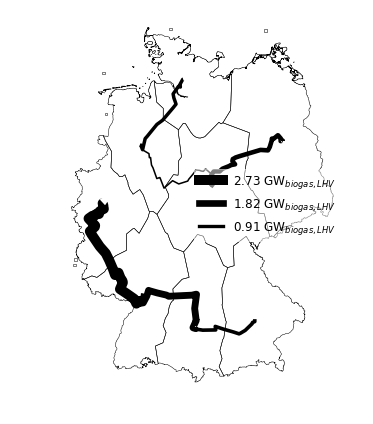

In [54]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (biogas)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)

In [55]:
esM.componentModelingDict['TransmissionModel'].optSummary

cluster_0  \
AC cables            TAC       [1e9 Euro/a]           cluster_0           0   
                                                      cluster_1           0   
                                                      cluster_2           0   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
                                                      cluster_6           0   
                                                      cluster_7           0   
                     capacity  [GW$_{el}$]            cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3     2.39577   
                                                      cluster_4     3.26266   
                                                      cluster_5     2.39577   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     capexCap  [1e9 Euro/a]           cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     invest    [1e9 Euro]             cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
...                                                                     ...   
Pipelines (hydrogen) invest    [1e9 Euro]             cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4  0.00124025   
                                                      cluster_5         NaN   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     operation [GW$_{H_{2},LHV}$*h/a] cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4      458.99   
                                                      cluster_5         NaN   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     opexCap   [1e9 Euro/a]           cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4           0   
                                     

In [56]:
fn.writeOptimizationOutputToExcel(esM, outputFileName='Results_Test')


Writing output to Excel... 
		(26.0155 sec)



In [57]:
import pandas as pd
file=pd.ExcelFile('Results_Test.xlsx')

In [58]:
trans = pd.read_excel(file, sheet_name=None)
trans.keys()
test = pd.read_excel(file, sheet_name='SourceSinkOptSummary')

In [59]:
esM.componentModelingDict['TransmissionModel'].optSummary

cluster_0  \
AC cables            TAC       [1e9 Euro/a]           cluster_0           0   
                                                      cluster_1           0   
                                                      cluster_2           0   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
                                                      cluster_6           0   
                                                      cluster_7           0   
                     capacity  [GW$_{el}$]            cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3     2.39577   
                                                      cluster_4     3.26266   
                                                      cluster_5     2.39577   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     capexCap  [1e9 Euro/a]           cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     invest    [1e9 Euro]             cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
...                                                                     ...   
Pipelines (hydrogen) invest    [1e9 Euro]             cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4  0.00124025   
                                                      cluster_5         NaN   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     operation [GW$_{H_{2},LHV}$*h/a] cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4      458.99   
                                                      cluster_5         NaN   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     opexCap   [1e9 Euro/a]           cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4           0   
                                     

In [60]:
df=esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
cluster_0,NaN,NaN,NaN,NaN,14.965040,NaN,NaN,NaN
cluster_1,NaN,NaN,9.565315,NaN,NaN,NaN,NaN,5.197288
cluster_2,NaN,9.565315,NaN,NaN,15.000000,NaN,NaN,NaN
cluster_3,NaN,NaN,NaN,NaN,4.542035,13.523569,NaN,NaN
cluster_4,14.96504,NaN,15.000000,4.542035,NaN,NaN,NaN,NaN
cluster_5,NaN,NaN,NaN,13.523569,NaN,NaN,NaN,NaN
cluster_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.584959
cluster_7,NaN,5.197288,NaN,NaN,NaN,NaN,2.584959,NaN


In [69]:
esM.componentModelingDict['TransmissionModel'].optSummary

cluster_0  \
AC cables            TAC       [1e9 Euro/a]           cluster_0           0   
                                                      cluster_1           0   
                                                      cluster_2           0   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
                                                      cluster_6           0   
                                                      cluster_7           0   
                     capacity  [GW$_{el}$]            cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3     2.39577   
                                                      cluster_4     3.26266   
                                                      cluster_5     2.39577   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     capexCap  [1e9 Euro/a]           cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     invest    [1e9 Euro]             cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3           0   
                                                      cluster_4           0   
                                                      cluster_5           0   
...                                                                     ...   
Pipelines (hydrogen) invest    [1e9 Euro]             cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4  0.00124025   
                                                      cluster_5         NaN   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     operation [GW$_{H_{2},LHV}$*h/a] cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4      458.99   
                                                      cluster_5         NaN   
                                                      cluster_6         NaN   
                                                      cluster_7         NaN   
                     opexCap   [1e9 Euro/a]           cluster_0         NaN   
                                                      cluster_1         NaN   
                                                      cluster_2         NaN   
                                                      cluster_3         NaN   
                                                      cluster_4           0   
                                     